In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sacc

import os

os.environ["CLMM_MODELING_BACKEND"] = (
    "ccl"  # Need to use NumCosmo as CLMM's backend as well.
)
import clmm  # noqa: E402
from clmm import Cosmology  # noqa: E402

import math
import itertools

from numcosmo_py import Nc
from numcosmo_py import Ncm

from astropy.table import Table

from astropy.io import fits
from scipy import stats
from typing import Any
import pyccl as ccl


## Import Redmapper Data


In [2]:
Omb = 0.02258 / 0.71**2
Omc = 0.1109 / 0.71**2


In [4]:
def generate_sacc_file() -> Any:
    """Generate a SACC file for cluster number counts and cluster deltasigma."""
    path = "/sps/lsst/groups/clusters/cl_pipeline_project/eduardo/CLCosmo_Sim_database"
    t = np.load(
        f"{path}/data/stacked_esd_profiles_redmapper_true_full_coverage.pkl",
        allow_pickle=True,
    )
    
    n_z_bins = 7
    n_rich_bins = 4
    n_radius_bins = 15
    n_cut = 4

    area = 439.78986

    
    richness_bins = np.log10(t["stacked profile"][0:n_rich_bins]["obs_bin"])
    redshift_bins = [t["stacked profile"][0 + n_rich_bins * i]["z_bin"] for i in range(n_z_bins)]
    radius_centers = t["stacked profile"][0]["radius"][n_cut:n_radius_bins]
    radius_bins = [[radius - 0.05, radius + 0.05] for radius in radius_centers]
    print(list(richness_bins), redshift_bins)

    s_count = sacc.Sacc()
    bin_z_labels = []
    bin_richness_labels = []
    bin_radius_labels = []

    survey_name = "cosmodc2"
    s_count.add_tracer("survey", survey_name, area)
    z_bins = []
    rich_bins = []
    for i, z_bin in enumerate(redshift_bins):
        lower, upper = z_bin
        bin_z_label = f"bin_z_{i}"
        s_count.add_tracer("bin_z", bin_z_label, lower, upper)
        bin_z_labels.append(bin_z_label)
        z_bins.append((lower,upper))
    for i, richness_bin in enumerate(richness_bins):
        lower, upper = richness_bin
        bin_richness_label = f"rich_{i}"
        s_count.add_tracer("bin_richness", bin_richness_label, lower, upper)
        bin_richness_labels.append(bin_richness_label)
        rich_bins.append((lower,upper))
    for i, radius_bin in enumerate(radius_bins):
        radius_lower, radius_upper = radius_bin
        j = i + 2
        radius_center = np.mean(radius_bins[i : j])
        bin_radius_label = f"bin_radius_{i}"
        s_count.add_tracer(
            "bin_radius", bin_radius_label, radius_lower, radius_upper, radius_center
        )
        bin_radius_labels.append(bin_radius_label)
    cluster_DeltaSigma = []
    mean_DeltaSigma = []
    cov_deltasigma = []
    cluster_counts = []
    for i in range(0, n_z_bins):
        for j in range(0, n_rich_bins):
            counts = t["stacked profile"][j + i * n_rich_bins]["n_stack"]
            cluster_counts.append(counts)
            # s_count.add_data_point(
            #     sacc.standard_types.cluster_counts,
            #     (survey_name, bin_z_labels[i], bin_richness_labels[j]),
            #     int(counts),
            # )
            for k in range(n_cut, n_radius_bins):
                profile = t["stacked profile"][j + i * n_rich_bins]["gt"][k]
                s_count.add_data_point(
                    sacc.standard_types.cluster_shear,
                    (
                        survey_name,
                        bin_z_labels[i],
                        bin_richness_labels[j],
                        bin_radius_labels[k-n_cut],
                    ),
                    profile,
                )
                mean_DeltaSigma.append(profile)

    counts_array = np.array(t["stacked profile"]["n_stack"])
    data = t['stacked covariance']['cov_t']
    diagonals = np.array([np.diag(matrix[n_cut:n_radius_bins,n_cut:n_radius_bins]) for matrix in data])
    cov_deltasigma = diagonals.flatten()
    cov_counts = []#counts_array.flatten()
    covariance = np.diag(np.concatenate([cov_counts, cov_deltasigma]))


    # ### Then the add the covariance and save the file
    s_count.add_covariance(covariance)
    s_count.to_canonical_order()
    s_count.save_fits("cosmodc2.sacc",overwrite=True)
    
    return mean_DeltaSigma, radius_centers, z_bins, rich_bins, s_count, n_z_bins, n_rich_bins, counts_array, covariance
    

if __name__ == "__main__":
    Ncm.cfg_init()
    mean_DeltaSigma_flat, rbins, z_bins, rich_bins, sac_s, nz, nr, counts, covariance = generate_sacc_file()

[array([1.30103   , 1.54406804]), array([1.54406804, 1.84509804]), array([1.84509804, 2.        ]), array([2.     , 2.30103])] [array([0.2, 0.3]), array([0.3, 0.4]), array([0.4, 0.5]), array([0.5, 0.6]), array([0.6, 0.7]), array([0.7, 0.8]), array([0.8, 1. ])]


## Read Sacc data

In [5]:
s_read = sacc.Sacc.load_fits("cosmodc2.sacc") 
data_points = s_read.get_data_points(f"{sacc.standard_types.cluster_shear}")
mean_DeltaSigma_read = [point.value for point in s_read.get_data_points(f"{sacc.standard_types.cluster_shear}")]
##Since we saved in redshift bins and then richness bins, this list will also be in this order
bin_DeltaSigma = [mean_DeltaSigma_read[i*len(rbins):i*len(rbins) + len(rbins)] for i in range(0, nz*nr)]
mean_DeltaSigma = [mean_DeltaSigma_flat[i*len(rbins):i*len(rbins) + len(rbins)] for i in range(0, nz*nr)]


### Comparing generated data to saved data

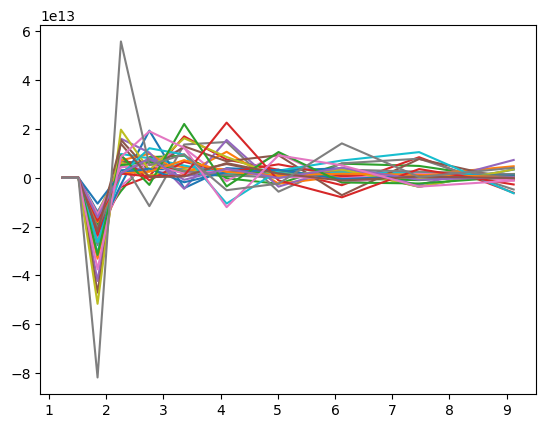

In [6]:
bin_ij = 0
for z_bin in range(nz):
    for rich_bin in range(nr):
        diff = np.array(bin_DeltaSigma[bin_ij]) - np.array(mean_DeltaSigma[bin_ij])
        plt.plot(rbins, diff)
        bin_ij+=1

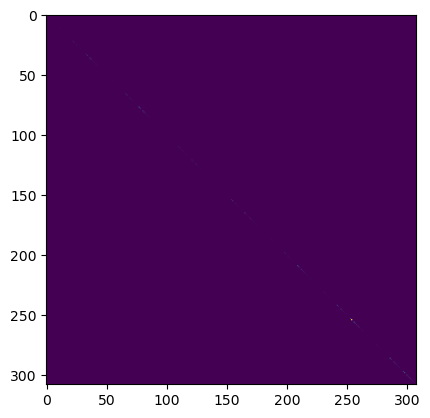

[ 0.00000000e+00  0.00000000e+00 -3.97702595e+24  2.27009005e+24
  4.16449793e+22  6.61467103e+23  4.13318938e+23  4.99582386e+23
 -1.72485996e+23  1.88643304e+23  7.47651864e+22  0.00000000e+00
  0.00000000e+00 -5.38233008e+24  2.65480017e+24 -9.19595146e+22
  2.42537979e+23  3.49949374e+23  1.22550971e+24  2.56760314e+23
  1.90971641e+23  5.53760404e+23  0.00000000e+00  0.00000000e+00
 -6.66633483e+25  5.68336005e+25 -4.16484540e+24  3.28611023e+24
  1.44873054e+24  4.51823949e+24  4.01588902e+24 -3.41756181e+24
  4.14318571e+24  0.00000000e+00  0.00000000e+00 -1.61692708e+26
  2.23182162e+25  1.12141938e+26 -1.19593750e+25  3.22767108e+25
 -2.94676987e+25  1.07332435e+25  2.74240790e+25 -1.77440509e+24
  0.00000000e+00  0.00000000e+00 -2.18553410e+24  6.06397404e+23
  2.15767282e+23  4.56429738e+23  2.56406168e+23  4.69940935e+23
  7.18862792e+22 -3.48603019e+20  1.09054896e+23  0.00000000e+00
  0.00000000e+00 -5.99884295e+24  1.32787855e+24  1.34705898e+24
  2.06534349e+24  1.27994

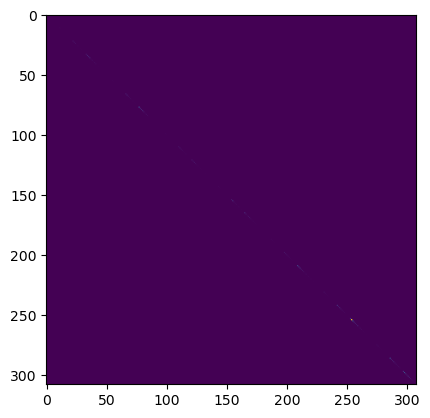

In [7]:
plt.imshow(s_read.covariance.covmat)
plt.show()
plt.imshow(covariance)
print(np.diagonal(s_read.covariance.covmat - covariance))
print(np.diagonal(s_read.covariance.covmat))
print(np.diagonal(covariance))

In [8]:
from firecrown.models.cluster.recipes.murata_binned_spec_z_deltasigma import MurataBinnedSpecZDeltaSigmaRecipe as MDS
from firecrown.models.cluster.deltasigma import ClusterDeltaSigma
from firecrown.models.cluster.deltasigma_data import DeltaSigmaData
from firecrown.models.cluster.abundance import ClusterAbundance
from firecrown.models.cluster.binning import SaccBin
from firecrown.models.cluster.properties import ClusterProperty
from firecrown.likelihood.binned_cluster_number_counts_deltasigma import BinnedClusterDeltaSigma

## Initiating mass function and defining parameters

In [9]:
hmf = ccl.halos.MassFuncDespali16(mass_def="200c")
min_mass, max_mass = 12.5, 15.5
min_z, max_z = 0.01, 1.2
cluster_abundance = ClusterAbundance((min_mass, max_mass), (min_z, max_z), hmf)
cluster_deltasigma = ClusterDeltaSigma((min_mass, max_mass), (min_z, max_z), hmf, False)
cosmo_ccl = ccl.Cosmology(
            Omega_b=0.0448, Omega_c=0.22, sigma8=0.8, w0=-1, wa=0, h=0.71, n_s=0.96
        )
sky_area = 400

## Reading data from SACC

### Calling functions by hand

In [10]:
DSD = DeltaSigmaData(s_read)
survey_nm = "cosmodc2"
data_type = sacc.standard_types.cluster_shear
##CHECK THIS ONE TOO
bin_combinations_for_survey = DSD._all_bin_combinations_for_data_type_and_survey(survey_nm, data_type, 4)
#print(bin_combinations_for_survey)
bins = []
for _, z_tracer, mass_tracer, radius_tracer in bin_combinations_for_survey:
    z_data: sacc.tracers.BinZTracer = sac_s.get_tracer(z_tracer)
    mass_data: sacc.tracers.BinRichnessTracer = sac_s.get_tracer(
        mass_tracer
    )
    radius_data: sacc.tracers.BinRadiusTracer = sac_s.get_tracer(
        radius_tracer
    )

    sacc_bin = SaccBin([z_data, mass_data, radius_data])
    bins.append(sacc_bin)

## Updating parameters in Notebook

In [11]:
cluster_deltasigma.update_ingredients(cosmo_ccl)
cluster_abundance.update_ingredients(cosmo_ccl)
mds = MDS()

mds.mass_distribution.__setattr__('mu_p0', 3.35)
mds.mass_distribution.__setattr__('mu_p1', 2.23 / np.log(10))
mds.mass_distribution.__setattr__('mu_p2', 0.06)
mds.mass_distribution.__setattr__('sigma_p0', 0.56)
mds.mass_distribution.__setattr__('sigma_p1', 0.10/ np.log(10))
mds.mass_distribution.__setattr__('sigma_p2', -0.05)
mds.mass_distribution.pivot_mass = np.log(10**14.3) 
mds.mass_distribution.pivot_redshift = 0.5
print(mds.mass_distribution.pivot_mass)
print(2.23 / np.log(10), 0.1 / np.log(10))

32.92696682981485
0.9684766946442515 0.04342944819032518


### Initiating statistic object from firecrown

In [12]:


bin_cl_theory = BinnedClusterDeltaSigma(ClusterProperty.DELTASIGMA, survey_nm, mds)
bin_cl_theory.read(s_read)

for i in range(len(bins)):
    print(f"{bin_cl_theory.bins[i].__str__().__eq__( bins[i].__str__())}\n")
    print(bin_cl_theory.bins[i].__str__())


True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (1.1883310994418628, 1.2883310994418629)]

True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (1.462207962854666, 1.5622079628546661)]

True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (9.074444023452758, 9.174444023452759)]

True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (1.796756862127835, 1.896756862127835)]

True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (2.2053446534571344, 2.305344653457134)]

True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (2.7026762015497483, 2.802676201549748)]

True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (3.311456112915036, 3.411456112915036)]

True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (4.054121773679276, 4.154121773679275)]

True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (4.9614783570513925, 5.061478357051392)]

True

[(0.2, 0.3), (1.3010299956639813, 1.5440680443502757), (6.069096535179

### Computing profile notebook

In [13]:

eval_list = []
eval_total = []
counts_total = []
for this_bin in bins:
    eval_u = mds.evaluate_theory_prediction(cluster_deltasigma,this_bin, sky_area, ClusterProperty.DELTASIGMA)
    eval_c = mds.evaluate_theory_prediction_counts(cluster_deltasigma,this_bin, sky_area)    
    eval_total.append(eval_u)
    counts_total.append(eval_c)
    eval_list.append(eval_u / eval_c)
eval_list = np.array(eval_list)
print(counts_total)

[140.666604153987, 140.666604153987, 140.666604153987, 140.666604153987, 140.666604153987, 140.666604153987, 140.666604153987, 140.666604153987, 140.666604153987, 140.666604153987, 140.666604153987, 63.26058492327945, 63.26058492327945, 63.26058492327945, 63.26058492327945, 63.26058492327945, 63.26058492327945, 63.26058492327945, 63.26058492327945, 63.26058492327945, 63.26058492327945, 63.26058492327945, 11.60419540470868, 11.60419540470868, 11.60419540470868, 11.60419540470868, 11.60419540470868, 11.60419540470868, 11.60419540470868, 11.60419540470868, 11.60419540470868, 11.60419540470868, 11.60419540470868, 7.802357917617704, 7.802357917617704, 7.802357917617704, 7.802357917617704, 7.802357917617704, 7.802357917617704, 7.802357917617704, 7.802357917617704, 7.802357917617704, 7.802357917617704, 7.802357917617704, 222.0289109808103, 222.0289109808103, 222.0289109808103, 222.0289109808103, 222.0289109808103, 222.0289109808103, 222.0289109808103, 222.0289109808103, 222.0289109808103, 222

### Computing profile Firecrown

In [14]:
from firecrown.modeling_tools import ModelingTools
tools = ModelingTools(cluster_abundance=cluster_abundance, cluster_deltasigma=cluster_deltasigma)

firecrown_pred = bin_cl_theory.get_binned_cluster_property(tools, ClusterProperty.DELTASIGMA)
firecrown_pred = np.array(firecrown_pred) 

In [15]:
truth_data = np.array(bin_DeltaSigma).flatten() #np.array(mean_DeltaSigma).flatten()
diff_nd =  (eval_list - truth_data) / truth_data
diff_nf = (eval_list - firecrown_pred) / firecrown_pred
diff_fd = (firecrown_pred - truth_data) / truth_data
print(f"Dfference between Notebook and data {diff_nd}")
print(f"Dfference between Notebook and Firecrown {diff_nf}")
print(f"Dfference between Firecrown and data {diff_fd}")

Dfference between Notebook and data [-7.14817801e-02 -2.71870681e-01 -1.01316829e-01 -8.17469368e-02
 -1.30873380e-01 -9.27083700e-02  1.02212095e-01 -6.16275951e-02
  2.32238902e-01 -8.35438284e-02 -2.44632306e-01 -4.14367964e-02
 -1.79803771e-01 -2.55577583e-01 -2.59518057e-01 -2.77235717e-01
 -2.34657280e-01 -2.17489499e-01 -1.74297258e-01 -3.62876604e-01
 -3.15197655e-01 -3.03644143e-01 -1.82719428e-01 -3.46299625e-01
  9.60743977e-01  4.34983274e-01 -1.18058017e-01 -8.63561121e-03
  5.03832818e-01  1.07019717e-01 -3.48607059e-01 -4.17658269e-02
  3.07679150e+00 -7.60603160e-02 -1.40114368e-01 -4.40695134e-01
  1.98362836e-01 -1.61055464e-01 -3.40228267e-01 -3.84241643e-02
  2.13832542e-01  2.86419846e-01 -3.07952580e-01  1.24312214e+00
 -3.96468841e-02 -2.24472974e-01 -3.51248115e-01 -1.39788185e-01
 -9.36040038e-02 -8.36008175e-02 -2.66040524e-01 -1.98378184e-01
 -2.13430794e-01 -3.65897327e-01 -4.87998582e-01  4.70859875e-02
 -1.34133034e-01 -1.31397221e-02 -1.68984991e-01 -1.38

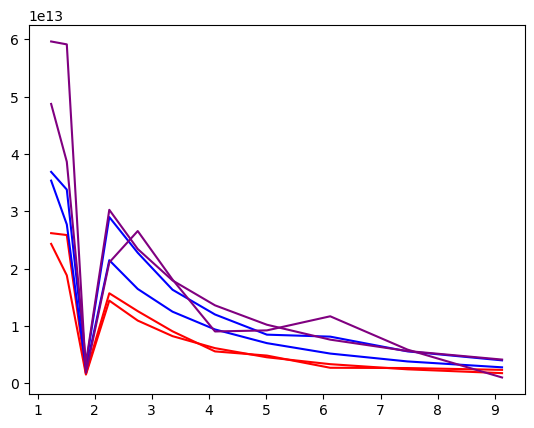

In [16]:
interval = len(rbins)
color = ['red', 'blue','purple']
for i in range(0,3):
    #plt.plot(rbins, firecrown_pred[i*interval : i*interval + interval], color=color[i])
    plt.plot(rbins, eval_list[i*interval : i*interval + interval], color=color[i])
    plt.plot(rbins, truth_data[i*interval : i*interval + interval], color=color[i])